## Information

Let's imagine you work on the product team at a medium-sized online e-commerce business. The UX designer worked really hard on a new version of the product page, with the hope that it will lead to a higher conversion rate. The product manager (PM) told you that **the current conversion rate is about 13%** on average throughout the year, and that **the team would be happy with an increase of 2%**, meaning that the new design will be **considered a success if it raises the conversion rate to 15%**.

## 1. Construct a hypothesis

Given that we don't know if the new design will perform better or worse (or the same?) as our current design, we'll choose a two-tailed test:

* Null hypothesis : The conversion rate of the new and old design is the same
* Alternative hypothesis : The conversion rate of the new and old design is different

$$H_0: p = p_0$$
$$H_a: p \ne p_0$$
where  𝑝  and  𝑝0  stand for the conversion rate of the new and old design, respectively.

We'll also set 

**confidence level of 95%**:

$$\alpha = 0.05$$

**Power = 0.8**:

$$(1 - \beta) = 0.8$$

In [207]:
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import LabelEncoder

## 2. Calculate sample size 
#### Method01

In [208]:
# Calculating effect size based on our expected rates
effect_size = sms.proportion_effectsize(0.13, 0.15)    

# Calculating sample size needed, we set the power to 0.8, and alpha to 0.05
required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )

# Rounding up to next whole number
required_n = math.ceil(required_n)                                                    

print('The sample size for one group: ',required_n)

The sample size for one group:  4720


#### Method02

In [209]:
def min_sample_size(bcr, mde, power=0.8, sig_level=0.05):
    """Returns the minimum sample size to set up a split test
    Arguments:
        1. bcr (float): probability of success for control, sometimes referred to as baseline conversion rate
        2. mde (float): minimum change in measurement between control group and test group
                       if alternative hypothesis is true, sometimes referred to as minimum detectable effect
        3. power (float): probability of rejecting the null hypothesis when the null hypothesis is false, typically 0.8
        4. sig_level (float): significance level often denoted as alpha, typically 0.05
    Returns:
        min_N: minimum sample size (float)
    References:
        Stanford lecture on sample sizes
        http://statweb.stanford.edu/~susan/courses/s141/hopower.pdf
    """
    # standard normal distribution to determine z-values
    standard_norm = stats.norm(0, 1)

    # find Z_beta from desired power
    Z_beta = standard_norm.ppf(power)

    # find Z_alpha (for two-tailed test)
    Z_alpha = standard_norm.ppf(1-sig_level/2)

    # average of probabilities from both groups
    pooled_prob = (bcr + bcr + mde) / 2
    
    ## the formula for Sample Size
    min_N = (2 * pooled_prob * (1 - pooled_prob) * (Z_beta + Z_alpha)**2
             / mde**2)

    return min_N

In [210]:
one_group_sample_size = min_sample_size(bcr=0.13, mde=0.02)
print("The sample size for one group:",int(one_group_sample_size))

The sample size for one group: 4725


## 3. Duration and Exposure

Usually after the sample size, we will decide on the exposure (What percentage of traffic is exposed) and how many days we need to collect enough data. However, since we already have the dataset this time, let's skip this step.

## 4. Preparing and  collecting the data

Usually at this point we need to work with our team or other teams to set up the AB test experiment, like Engineering team to make sure we collect enough data for the experiment.

But this time, we use <a href='https://www.kaggle.com/zhangluyuan/ab-testing?select=ab_data.csv'> the dataset from Kaggle</a>

### I. Basic infomaiton of data

In [211]:
# import the data

df_original = pd.read_csv('ab_data.csv')

In [212]:
df = df_original.copy()
df

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [213]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [214]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [215]:
print(df['converted'].value_counts())

# calculate old design's Conversion Rate
old_conversion_rate = round(df['converted'].value_counts()[1]/len(df),2)
print('')
print(f'Conversion Rate of Old Design: {old_conversion_rate}%' )

0    259241
1     35237
Name: converted, dtype: int64

Conversion Rate of Old Design: 0.12%


### II. Data Processing

In [216]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


#### - From above chart, there are some users who have seen the wrong page

In [217]:
# Delete control group's users who have already seen the wrong page
wrong_group_control_user = df[(df['group'] == 'control') & (df['landing_page'] =='new_page')].index
df = df[~df.index.isin(wrong_group_control_user)]

# Delete treatment group's users who have already seen the wrong page
wrong_group_treatment_user = df[(df['group'] == 'treatment') & (df['landing_page'] =='old_page')].index
df = df[~df.index.isin(wrong_group_treatment_user)]

In [218]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,0,145274
treatment,145311,0


* Now, there is no user who have seen the wrong page

#### - Check if there is any user that have been sampled multiple times

In [219]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 1 users that appear multiple times in the dataset


In [220]:
drop_multi_users = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(drop_multi_users)]
print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 290583 entries


### III. Sampling

In [221]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=1)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=1)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)

ab_test.sample(15)

,user_id,timestamp,group,landing_page,converted
5917,748629,2017-01-17 17:50:51.305023,treatment,new_page,0
7236,711608,2017-01-11 22:32:06.462850,treatment,new_page,0
2090,863128,2017-01-06 06:08:42.380208,control,old_page,0
2511,908291,2017-01-12 23:29:44.924334,control,old_page,0
9091,789311,2017-01-16 11:54:49.028404,treatment,new_page,0
6975,691532,2017-01-06 07:28:25.483634,treatment,new_page,0
9395,780067,2017-01-11 07:05:54.870012,treatment,new_page,0
4914,712433,2017-01-10 04:09:11.233712,treatment,new_page,0
8842,674212,2017-01-19 02:41:40.678225,treatment,new_page,0
6185,700990,2017-01-18 09:16:12.758470,treatment,new_page,0


In [222]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [223]:
two_groups_samples = ab_test['group'].value_counts()
two_groups_samples

control      4720
treatment    4720
Name: group, dtype: int64

### IV. Sanity Check

In [224]:
# z(95%)

total_sample_size = two_groups_samples.sum()
control_sample_size = two_groups_samples['control']
treatment_sample_size = two_groups_samples['treatment']

# standard deviation
SD = math.sqrt(0.5 * 0.5 / (total_sample_size))

# margin (wiht 95% confidence)
margin = 1.96 * SD

# higher & lower boundary
low_boundary = 0.5 - margin
high_boundary = 0.5 + margin

print('Lower boundary: ', round(low_boundary,4))
print('Higher boundary: ', round(high_boundary,4))
print('Observed: ', round(control_sample_size/(total_sample_size),4))

Lower boundary:  0.4899
Higher boundary:  0.5101
Observed:  0.5


* **Pass the Sanity Check**

## 4. Visualising the results

In [225]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x, ddof=0)              # Std. deviation of the proportion
se_p = lambda x: stats.sem(x, ddof=0)            # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.119,0.323,0.005
treatment,0.122,0.327,0.005


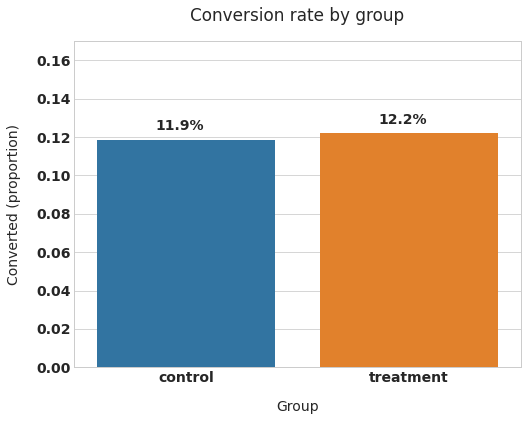

In [235]:
plt.figure(figsize=(8,6))

ax = sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)
for p in ax.patches:
    ax.text(p.get_x() + 0.265,
            p.get_height()+0.005, 
            f'{p.get_height()*100:.1f}%') 

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

* The treatment group's Conversion rate is slightly higher than control group's(11.9% vs. 12.2%). 
* **Is this difference statistically significant?**

## 5. Analyze result

### Method01 - Testing the hypothesis 

In [241]:
# use the statsmodels.stats.proportion module to get the p-value and confidence intervals:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# get each group's result
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

# the sample size of each group
n_con = control_results.count()
n_treat = treatment_results.count()
nobs = [n_con, n_treat]

# the number of converted of each group
successes = [control_results.sum(), treatment_results.sum()]

# Calculate the p-value and confidence intervals
z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'confidence interval 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'confidence interval 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.51
p-value: 0.613
confidence interval 95% for control group: [0.109, 0.128]
confidence interval 95% for treatment group: [0.113, 0.131]


### Method02 - Check statistically & practically siginficant 

In [248]:
# practical significance level (we want Conversion Rate increase 2%)
prctical_b = 0.02


# get each group's result
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

# the sample size of each group
n_con = control_results.count()
n_treat = treatment_results.count()

# the number of converted of each group
x_converted_con = control_results.sum()
x_converted_treat = treatment_results.sum()

# pooled probability
p_pool = (x_converted_con+x_converted_treat) / (n_con+n_treat)

# Standard Error
SE = math.sqrt(p_pool*(1-p_pool)*(1/n_con+1/n_treat))

# Margin
m = 1.96*SE

# difference between control and treatment group
cr_con = x_converted_con / n_con
cr_treat = x_converted_treat / n_treat
d_hat = cr_treat - cr_con

low = d_hat - m
high = d_hat + m

Statist_signifi = (high<0 or low>0)
Practic_signifi = ((prctical_b>low and prctical_b<high) or (-prctical_b>low and -prctical_b<high))

print(f'Confidence Interval: [{low:.4f},{high:.4f}]')
print(f'Observed: {d_hat: .4f}')

if (Statist_signifi == True):
    print('Statistically significant: Yes! CI does not include 0.')
else:
    print('Statistically significant: No! CI includes 0.')

if (Practic_signifi == False):
    print(f'Practically significant: Yes! CI does not include d_min ({prctical_b}).')
else:
    print(f'Practically significant: No! CI includes d_min ({prctical_b}).')       


Confidence Interval: [-0.0097,0.0165]
Observed:  0.0034
Statistically significant: No! CI includes 0.
Practically significant: Yes! CI does not include d_min (0.02).


### Analysis

* **From Analysis Method01:**

    Since our $p$-value=0.613 is way higher than our $\alpha$=0.05, we cannot reject the null hypothesis $H_0$, which means that **the new design is not significantly different from our old design**

* **From Analysis Method02:**

    It is practically significant, but not statistically significant. Therefore, **the new design's performance was not significantly different from our old design**

## 6. Conclusions

* The new design's performance was **not significantly different** from our old design

* Our new design doesn't improve our conversion rate as much as we hope, we **should not replace the old one with this new design**.